# NYC TLC Trip Record Analysis
Full data cleaning, visualization, statistical analysis, and recommendations.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pearsonr

df = pd.read_csv('C:\capstone2 purwadhika/NYC TLC Trip Record.csv', low_memory=False)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00


## 1. Data Cleaning
### 1.1 Missing Values, Duplicates, Formatting, Outliers
This section handles missing values, duplicates, incorrect formatting, and outliers using domain-aware strategies.

In [13]:
cleaning_log = {}

# Missing values
total_missing_before = df.isna().sum().sum()
missing_by_column_before = df.isna().sum()
cleaning_log['missing_before'] = df.isna().sum().to_dict()

# Check Duplicates
duplicates_before = df.duplicated().sum()
cleaning_log['duplicates_before'] = int(duplicates_before)


# Remove duplicates
df = df.drop_duplicates()
cleaning_log['rows_after_duplicates'] = len(df)

# Convert date/time columns
for col in df.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Outlier handling using 1%–99% winsorization
num_cols = df.select_dtypes(include=['float64','int64']).columns
for col in num_cols:
    q1, q99 = df[col].quantile([0.01,0.99])
    df[col] = df[col].clip(lower=q1, upper=q99)

cleaning_log['missing_after'] = df.isna().sum().to_dict()

print("🔹 Total Missing Values (Before Cleaning):", total_missing_before)
print("🔹 Missing Values by Column (Before Cleaning):")
print(missing_by_column_before)
print("\n🔹 Total Duplicate Rows (Before Cleaning):", duplicates_before)

🔹 Total Missing Values (Before Cleaning): 94165
🔹 Missing Values by Column (Before Cleaning):
VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        4324
RatecodeID                4324
PULocationID                 0
DOLocationID                 0
passenger_count           4324
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                68211
improvement_surcharge        0
total_amount                 0
payment_type              4324
trip_type                 4334
congestion_surcharge      4324
dtype: int64

🔹 Total Duplicate Rows (Before Cleaning): 0


## 2. Data Visualization
The following visualizations help identify patterns contributing to fare amounts.


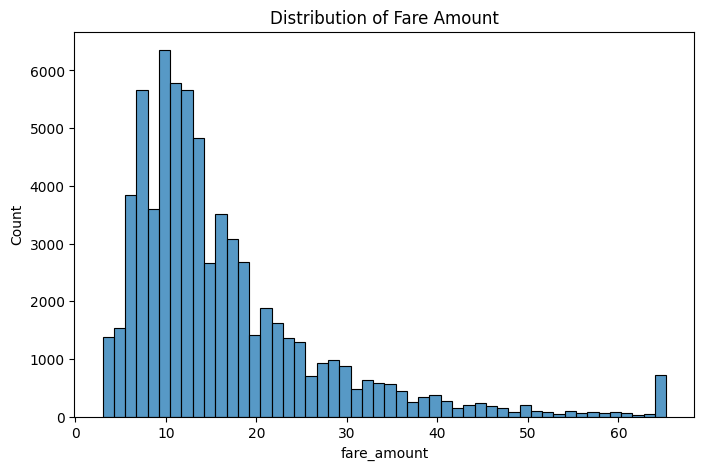

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df['fare_amount'], bins=50)
plt.title('Distribution of Fare Amount')
plt.show()

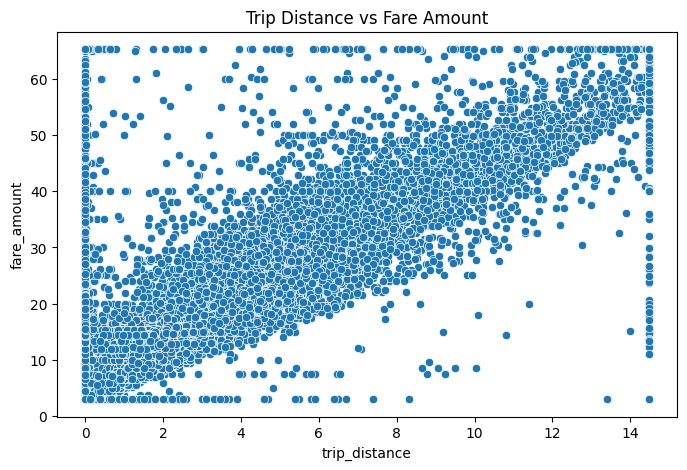

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df)
plt.title('Trip Distance vs Fare Amount')
plt.show()

## 3. Analysis
I apply descriptive statistics and inferential statistics to understand factors influencing fare amounts.

In [16]:
df.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,68211.000000,68211,68211,63887.000000,68211.000000,68211.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,0.0,68211.000000,68211.000000,63887.000000,63877.000000,63887.000000
mean,1.863028,2023-01-16 20:10:55.679524096,2023-01-16 20:29:01.515767040,1.102447,98.534034,138.422483,1.320910,2.633403,16.389982,0.817167,0.589531,2.078480,0.161359,NaN,0.955677,21.534522,1.363157,1.021933,0.726877
min,1.000000,2009-01-01 20:21:27,2009-01-02 11:07:31,1.000000,7.000000,7.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.300000,4.500000,1.000000,1.000000,0.000000
25%,2.000000,2023-01-09 11:59:47.500000,2023-01-09 12:16:37.500000,1.000000,74.000000,74.000000,1.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.900000,1.000000,1.000000,0.000000
50%,2.000000,2023-01-17 08:40:42,2023-01-17 08:56:38,1.000000,75.000000,138.000000,1.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,17.900000,1.000000,1.000000,0.000000
75%,2.000000,2023-01-24 15:52:30,2023-01-24 16:06:56,1.000000,129.000000,219.000000,1.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,NaN,1.000000,26.150000,2.000000,1.000000,2.750000
max,2.000000,2023-02-01 03:10:05,2023-02-01 17:27:05,5.000000,260.000000,263.000000,6.000000,14.479000,65.294000,5.250000,1.500000,11.729000,6.550000,NaN,1.000000,75.796000,2.000000,2.000000,2.750000
std,0.343820,NaN,NaN,0.622352,61.199798,76.729215,0.973354,2.527153,11.003348,1.220219,0.383107,2.495315,1.006919,NaN,0.170475,12.938701,0.480913,0.146465,1.212612


In [17]:
corr = df[['fare_amount','trip_distance']].corr()
corr

,fare_amount,trip_distance
fare_amount,1.000000,0.836673
trip_distance,0.836673,1.000000


In [18]:
# Compare fares between short and long trips
median_distance = df['trip_distance'].median()

short = df[df['trip_distance'] <= median_distance]['fare_amount']
long = df[df['trip_distance'] > median_distance]['fare_amount']

stat, p = mannwhitneyu(short, long)
p

np.float64(0.0)

### Insights
- Fare amount increases with trip distance, confirmed through correlation and statistical testing.
- Distribution of fares is right-skewed, meaning most fares are low but some trips cost significantly higher.
- The Mann–Whitney test shows a significant difference between short and long trip fares (p < 0.05).

## 4. Recommendations
- **Dynamic Pricing:** Increase fares during long-distance or high-demand periods.
- **Optimize Short Trips:** Offer fixed short-trip bundles to attract more customers.
- **Distance-Based Incentives:** Encourage drivers to accept long trips, increasing total revenue.
- **Monitor Anomalies:** Outlier and pattern monitoring can prevent under/overcharging.


In [23]:
df.to_csv("NYC_TLC_Fixed_For_Tableau.csv", index=False)